# Práctica de calibración de cámaras

Visión por Computador <br>
Practica 2. 2 de noviembre de 2020

Adrián Michelena Sanz

Alberto Miño Calero

Este enunciado está en el archivo "PracticaCalib2020.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Dos secuencias de imágenes tomadas con un par de cámaras estéreo (izquierda y derecha) en los directorios ``left`` y ``right``.
* Un conjunto de imágenes de alta resolución un edificio, ``building``.

## Condiciones

* La fecha límite de entrega será el lunes 9 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [ ]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
#import scipy.misc as scpm
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

'''
# Prueba
original = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/left/left_018.jpg"
original = cv2.cvtColor(cv2.imread(original), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(original)
print(original.shape)

imageList = []
imageList.append(original)
plt.figure()
plt.imshow(imageList[0])
'''

Mounted at /gdrive


'\n# Prueba\noriginal = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/left/left_018.jpg"\noriginal = cv2.cvtColor(cv2.imread(original), cv2.COLOR_BGR2RGB)\nplt.figure()\nplt.imshow(original)\nprint(original.shape)\n\nimageList = []\nimageList.append(original)\nplt.figure()\nplt.imshow(imageList[0])\n'

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [ ]:
def load_images(filenames):
    """Load multiple images."""
    imageList = []
    for path in filenames:
      image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
      imageList.append(image)
    return imageList

def load_gray_images(filenames):
    """Load multiple gray scale images."""
    imageList = []
    for path in filenames:
      image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
      imageList.append(image)
    return imageList

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [ ]:
leftpath = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/left/*.jpg"
rightpath = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/right/*.jpg"

leftFiles = glob.glob(leftpath)
rightFiles = glob.glob(rightpath)

leftFiles = sorted(leftFiles)
rightFiles = sorted(rightFiles)

leftImages = load_images(leftFiles)
rightImages = load_images(rightFiles)

grayLeftImages = load_gray_images(leftFiles)
grayRightImages = load_gray_images(rightFiles)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [ ]:
leftImagesCorners = []
leftImagesCornersBool = []
c=0

for i in grayLeftImages:
  ret, aux = cv2.findChessboardCorners(i, (8,6))
  leftImagesCorners.append(aux)
  leftImagesCornersBool.append(ret)

In [ ]:
# This section is OPTIONAL
# cornerSubPix is destructive. so we copy standard corners and use the new list to refine
leftImagesCornersRefined = copy.deepcopy(leftImagesCorners)

# Refine corner estimation (images mus be in b&w, use cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) to convert from rgb)
# termination criteria (see, e.g https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

c = 0
for i in grayLeftImages:
  # Utilizamos un tamaño de ventana de 5,5 porque es el que mejor resultado nos ha dado a la hora de corregir esquinas
  if leftImagesCornersBool[c] == True:
    cv2.cornerSubPix(i, leftImagesCornersRefined[c], (5,5), (-1,-1), criteria)
  c+=1

# La corrección permite mejorar la posición de las esquinas en el patrón, especialmente en el caso de la imagen 0,
# que está más inclinada, y en donde findChessboardCorners muestra esquinas alineadas con una mayor distorsión 
# print(leftImagesCornersRefined[i])

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

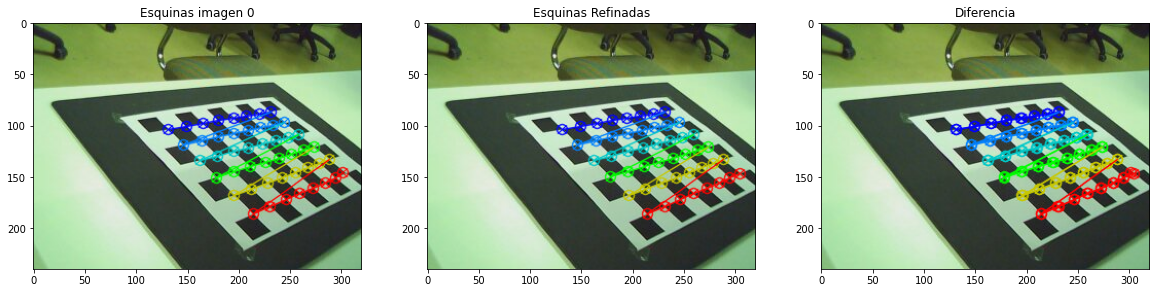

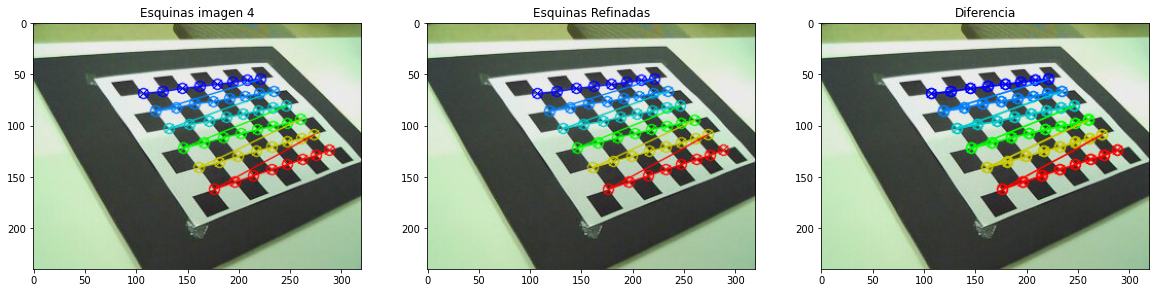

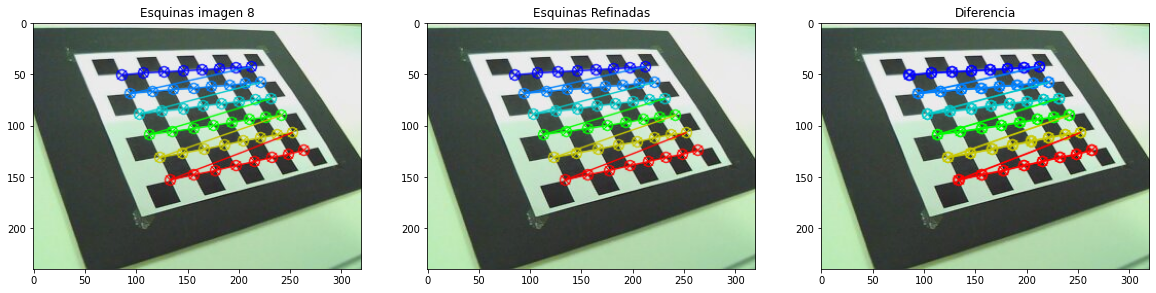

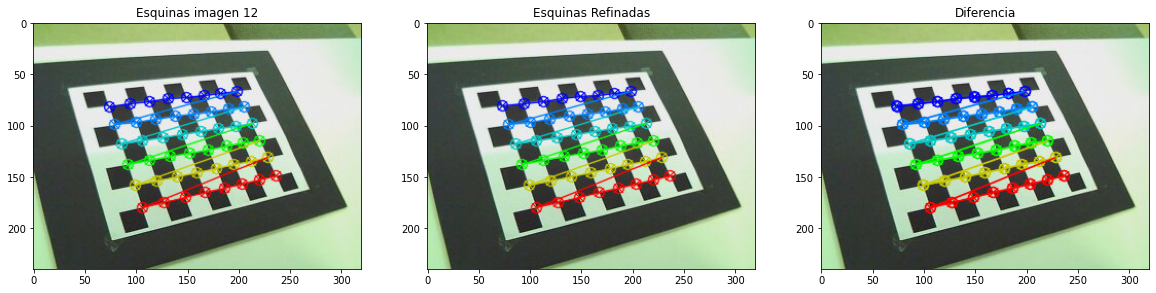

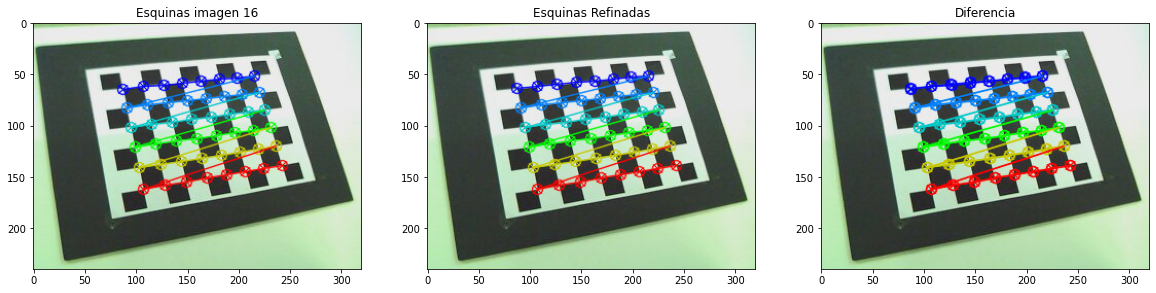

In [ ]:
leftImagesNormal = copy.deepcopy(leftImages)
leftImagesRefined = copy.deepcopy(leftImages)
leftImagesRefinedDif = copy.deepcopy(leftImages)

c = 0
for i in grayLeftImages:
  if leftImagesCornersBool[0] == True:
    cv2.drawChessboardCorners(leftImagesNormal[c],(8,6), leftImagesCorners[c], leftImagesCornersBool[c])
    cv2.drawChessboardCorners(leftImagesRefined[c],(8,6), leftImagesCornersRefined[c], leftImagesCornersBool[c])
    if c%4==0:
      f, axs = plt.subplots(1, 3, figsize=(20,20))
      axs[0].set_title('Esquinas imagen {}'.format(c))
      axs[0].imshow(leftImagesNormal[c])
      axs[1].set_title('Esquinas Refinadas')
      axs[1].imshow(leftImagesRefined[c])
      cv2.drawChessboardCorners(leftImagesRefinedDif[c],(8,6), leftImagesCorners[c], leftImagesCornersBool[c])
      cv2.drawChessboardCorners(leftImagesRefinedDif[c],(8,6), leftImagesCornersRefined[c], leftImagesCornersBool[c])
      axs[2].set_title('Diferencia')
      axs[2].imshow(leftImagesRefinedDif[c])
      plt.show()
  c+=1

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [ ]:
def get_chessboard_points(chessboard_shape, dx, dy):
    numPoints = chessboard_shape[0]*chessboard_shape[1]
    corners = np.ndarray(shape=(numPoints,3))
    x = 0
    for i in range(chessboard_shape[1]):
        y = 0
        for j in range(chessboard_shape[0]):
            index = i*chessboard_shape[0]+j
            corners[index][0] = x
            corners[index][1] = y
            corners[index][2] = 0
            y += dy
        x += dx
    return corners

test = get_chessboard_points((8,6),30,30)
print(test)

[[  0.   0.   0.]
 [  0.  30.   0.]
 [  0.  60.   0.]
 [  0.  90.   0.]
 [  0. 120.   0.]
 [  0. 150.   0.]
 [  0. 180.   0.]
 [  0. 210.   0.]
 [ 30.   0.   0.]
 [ 30.  30.   0.]
 [ 30.  60.   0.]
 [ 30.  90.   0.]
 [ 30. 120.   0.]
 [ 30. 150.   0.]
 [ 30. 180.   0.]
 [ 30. 210.   0.]
 [ 60.   0.   0.]
 [ 60.  30.   0.]
 [ 60.  60.   0.]
 [ 60.  90.   0.]
 [ 60. 120.   0.]
 [ 60. 150.   0.]
 [ 60. 180.   0.]
 [ 60. 210.   0.]
 [ 90.   0.   0.]
 [ 90.  30.   0.]
 [ 90.  60.   0.]
 [ 90.  90.   0.]
 [ 90. 120.   0.]
 [ 90. 150.   0.]
 [ 90. 180.   0.]
 [ 90. 210.   0.]
 [120.   0.   0.]
 [120.  30.   0.]
 [120.  60.   0.]
 [120.  90.   0.]
 [120. 120.   0.]
 [120. 150.   0.]
 [120. 180.   0.]
 [120. 210.   0.]
 [150.   0.   0.]
 [150.  30.   0.]
 [150.  60.   0.]
 [150.  90.   0.]
 [150. 120.   0.]
 [150. 150.   0.]
 [150. 180.   0.]
 [150. 210.   0.]]


**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

In [ ]:
def calibration(image_corners, image_cornersRet, cb_points, image_size):
  # Extract the list of valid images with all corners
  valid_corners = []
  for i, c in zip(image_corners,image_cornersRet):
    if c:
      valid_corners.append(i)

  num_valid_images = len(valid_corners)
  # Prepare input data
  # object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
  object_points = np.array([cb_points]*num_valid_images, dtype=np.float32)

  # image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
  image_points = np.array([icorner[:,0,:] for icorner in valid_corners], dtype=np.float32)

  # Es necesario declarar la matriz de intrínsecos y la de distorsión de coeficientes 
  # porque son entradas de la función de calibración
  intrinsics = np.identity(3)
  dist_coeffs = np.zeros(1)

  # Calibrate for square pixels corners standard
  rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image_size, intrinsics, dist_coeffs, flags=cv2.CALIB_FIX_ASPECT_RATIO)

  return rms, intrinsics, dist_coeffs, rvecs, tvecs, object_points



# Dimensiones de la imagen
image_size = leftImages[0].shape[0:2]

# Lista de puntos del objeto según su sistema de referencia
cb_points = get_chessboard_points((8,6),30,30)

# Calibración de cámara y extracción de parámetros
rms, intrinsics, dist_coeffs, rvecs, tvecs, object_points  = calibration(leftImagesCornersRefined, leftImagesCornersBool, cb_points, image_size)

print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:", dist_coeffs[:])
print("rms:", rms)

Corners standard intrinsics:
 [[421.55031138   0.         149.53480917]
 [  0.         421.55031138 127.88442732]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs: [[-5.92686666e-02]
 [-1.40096254e+00]
 [ 4.69767304e-03]
 [-6.62847381e-03]
 [ 7.09404209e+00]]
rms: 0.09386126655921352


###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

El ejercicio está implementado de forma analítica. Las bases para hacerlo consisten en lo siguiente.
Se pide calcular el ángulo de la diagonal de una región del plano imagen de tamaño 50x50 pixeles. 

En relación con este angulo, se puede dibujar un triangulo rectángulo con ángulo recto en el segmento que une el punto medio de la diagonal con el centro de la cámara, y la diagonal. Este segmento mide la focal correspondiente, en pixeles, mientras que el otro cateto del triangulo rectángulo se corresponde con la mitad del lado de la región rectangular, también en pixeles.

Conocemos la matriz de intrínsecos, sabemos el valor de alfa y beta, las focales de la cámara. También conocemos lo que miden los lados vertical y horizontal de las regiones. Tenemos por tanto un triangulo rectángulo, y mediante la relación trigonométrica tangente, podemos decir que la tangente de la mitad del ángulo es igual (aplicando pitágoras) a la raiz cuadrada de la suma de los cuadrados de la mitad de los catetos (los lados de la región rectangular) divididos entre las focales. 

Cómo queremos el angulo de la diagonal y no de la mitad, calculamos la arcotangente para valor y multiplicamos por 2.

In [ ]:
# Devuelve en radianes
def fov(intrinsicK, image_size):
  x_focal = intrinsicK[0][0]
  y_focal = intrinsicK[1][1]
  width = image_size[0]
  height = image_size[1]
  angle = 2 * math.atan(math.sqrt(pow((width/(2*y_focal)), 2) + 
                                  pow((height/(2*x_focal)), 2))
                      )
  return angle

def radians2degrees(radians):
  degrees = (radians * 180) / math.pi
  return degrees

region_size = (50,50)
radianAngle = fov(intrinsics, region_size)
print("Angulo radianes de la región (10,10) - (60,60):",radianAngle)
print("Angulo grados de la región (10,10) - (60,60)::",radians2degrees(radianAngle))

Angulo radianes de la región (10,10) - (60,60): 0.16734794429250152
Angulo grados de la región (10,10) - (60,60):: 9.588330918150751


**Ejercicio 6.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``left_002.jpg``  y ``left_0014.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

---
Planteamiento Analítico
---
Para hacer este ejercicio, el planteamiento analítico es el siguiente. 
Se conoce la matriz de intrínsecos, los extrínsecos de rotación y los extrínsecos de traslación. Los intrínsecos estimados de la cámara se mantienen, mientras que entre las imágenes variarán los extrínsecos de cada una, y es base a esta variación que se estimará la distancia que se ha trasladado la cámara.

Para ello, teniendo en cuenta lo que nos ofrece la función de calibración, lo primero es calcular las matrices de rotación a partir de los vectores de rotación que tenemos de cada imagen. Se hace con la función de opencv Rodrigues, que nos devuelve una lista cuya primera posición es dicha matriz.

Una vez se tienen ambas matrices de rotación, se puede calcular la traslación de la cámara de una imagen a la otra representando la segunda imagen en el sistema de referencia de la primera. Para ello, se hace una multiplicación punto a punto en donde la de rotación de la segunda se multiplica con otra multiplicación punto a punto de la traspuesta de rotación de la primera con la de traslación de la priemra, y a ello se le suma la de traslación de la segunda. 

Esto nos da un vector de desplazamiento, al que se le puede calcular su módulo, que será la estimación del desplazamiento de la cámara entre ambas imágenes.

In [ ]:
#R_1to2 = rvecs[2] * np.transpose(rvecs[14])

rvecs2 = cv2.Rodrigues(rvecs[2])
rvecs14 = cv2.Rodrigues(rvecs[14])

tvec_1to2 = np.dot(rvecs14[0], np.dot(-np.transpose(rvecs2[0]),tvecs[2]))  + tvecs[14];


print("Distancia de desplazamiento de la cámara:",np.linalg.norm(tvec_1to2),"mm")

Distancia de desplazamiento de la cámara: 294.3356775674705 mm


## 2. Par de cámaras estéreo

**Ejercicio 7.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras de par estéreo?

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: Calibra la cámara derecha usando la secuencia de imágenes del directorio ``right`` y estima dicha distancia.

---
Planteamiento Analítico
---

Este ejercicio se basa en lo mismo que el anterior, con algunas diferencias. En este caso, se quiere averiguar la distancia entre dos cámaras. Al ser cámaras de par estéreo, se puede asumir que sus intrínsecos van a ser iguales. A partir de esto, podemos averiguar la distancia calculando el desplazamiento en base a los extrínsecos para cada par de imágenes tomadas de la misma escena con cada cámara. Se hace lo mismo, representar la imagen de una en el sistema de referencias de la otra, y calcular la distancia como si se tratase de un desplazamiento de cámara en lugar de dos cámaras diferentes (de nuevo, porque son de par estéreo).

Dado que tenemos un conjunto de imágenes, lo que se hará será estimar la distancia entre cada par tomadas de la misma escena, y calcular la media de las distancias.

In [ ]:
rightImagesCorners = []
rightImagesCornersBool = []

for i in grayRightImages:
  ret, aux = cv2.findChessboardCorners(i, (8,6))
  rightImagesCorners.append(aux)
  rightImagesCornersBool.append(ret)

rightImagesCornersRefined = copy.deepcopy(rightImagesCorners)

c = 0
for i in grayRightImages:
  # Utilizamos un tamaño de ventana de 5,5 porque es el que mejor resultado nos ha dado a la hora de corregir esquinas
  if rightImagesCornersBool[c] == True:
    cv2.cornerSubPix(i, rightImagesCornersRefined[c], (5,5), (-1,-1), criteria)
  c+=1

# Dimensiones de la imagen
image_sizeR = rightImages[0].shape[0:2]

# Lista de puntos del objeto según su sistema de referencia
cb_pointsR = get_chessboard_points((8,6),30,30)

# Calibración de cámara y extracción de parámetros
rmsR, intrinsicsR, dist_coeffsR, rvecsR, tvecsR, object_pointsR  = calibration(rightImagesCornersRefined, rightImagesCornersBool, cb_pointsR, image_sizeR)

i=0
correct = 0
distanciaCams=0
print(len(rvecs))
print(len(rvecsR))
for a in rightImagesCornersBool:
  if a == True and leftImagesCornersBool[i] == True:
    #R_1to2Cam = rvecs[i] * np.transpose(rvecsR[correct])
    rvecsiL = cv2.Rodrigues(rvecs[i])
    rvecsiR = cv2.Rodrigues(rvecsR[correct])

    tvec_1to2Cam = np.dot(rvecsiR[0], np.dot(-np.transpose(rvecsiL[0]),tvecs[i]))  + tvecsR[correct];
    distanciaCams += np.linalg.norm(tvec_1to2Cam)
    print("Distancia de desplazamiento de la cámara en las fotos ",i," :",np.linalg.norm(tvec_1to2Cam))
    correct+=1
  i+=1

if correct>0:
  distanciaCams = distanciaCams/correct

# Hay que revisar bien lo de que compare cada imagen con su homonima de la derecha
print("Distancia entre camaras:",distanciaCams)

19
17
Distancia de desplazamiento de la cámara en las fotos  0  : 61.057216930274315
Distancia de desplazamiento de la cámara en las fotos  2  : 60.40903077643965
Distancia de desplazamiento de la cámara en las fotos  3  : 58.77556939160455
Distancia de desplazamiento de la cámara en las fotos  4  : 60.656307235656264
Distancia de desplazamiento de la cámara en las fotos  5  : 59.83006618160828
Distancia de desplazamiento de la cámara en las fotos  6  : 59.21741439123852
Distancia de desplazamiento de la cámara en las fotos  7  : 61.63072861824534
Distancia de desplazamiento de la cámara en las fotos  8  : 61.07233820650773
Distancia de desplazamiento de la cámara en las fotos  9  : 60.26492526880406
Distancia de desplazamiento de la cámara en las fotos  10  : 59.09934909880562
Distancia de desplazamiento de la cámara en las fotos  11  : 60.573034295441225
Distancia de desplazamiento de la cámara en las fotos  12  : 59.05504026063107
Distancia de desplazamiento de la cámara en las foto

## 3. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 8.** Se desea estimar la rotación que ha sufrido la cámara entre las imágenes ``build_001`` y ``build_003``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: En primer lugar estudia si es posible estimar los  intrínsecos de la cámara a partir de dichas imágenes y, a continuación, estima la rotación entre ellas.

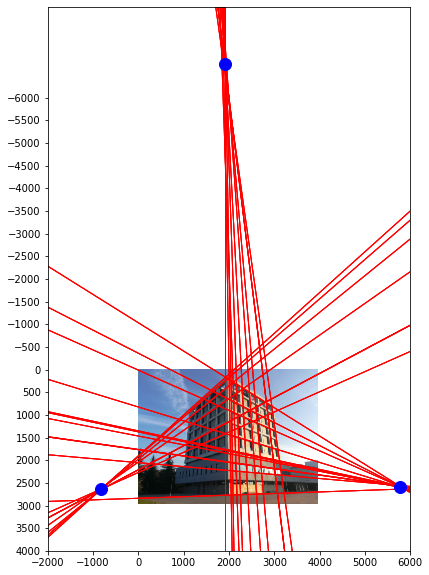

Puntos de fuga de la imagen build1: [5772.71875, 2585.40625] [1912.08, -6754.52] [-819.3333333333334, 2639.1666666666665]


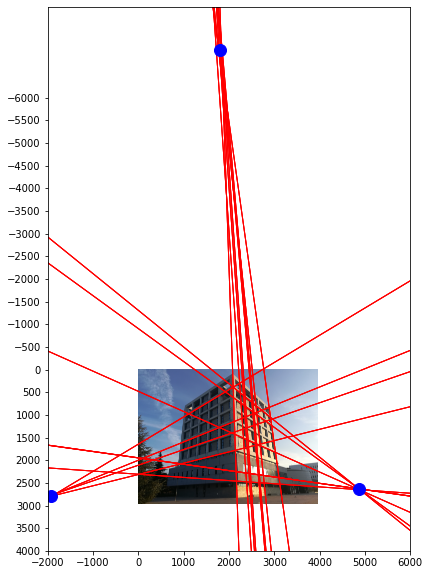

In [ ]:
pathbuild1 = '/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/building/build_001.jpg'
pathbuild3 = '/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P2/building/build_003.jpg'

from collections import defaultdict
from matplotlib import colors
import sys
import matplotlib as mpl

def segment_by_angle_kmeans(lines, k=3, **kwargs):
    """
    Group lines by their angle using k-means clustering.

    Code from here:
    https://stackoverflow.com/a/46572063/1755401
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))

    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # Get angles in [0, pi] radians
    angles = np.array([line[0][1] for line in lines])

    # Multiply the angles by two and find coordinates of that angle on the Unit Circle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)] for angle in angles], dtype=np.float32)

    # Run k-means
    if sys.version_info[0] == 2:
        # python 2.x
        ret, labels, centers = cv2.kmeans(pts, k, criteria, attempts, flags)
    else: 
        # python 3.x, syntax has changed.
        labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]

    labels = labels.reshape(-1) # Transpose to row vector

    # Segment lines based on their label of 0 or 1
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        if line[0][1]!=0:
          segmented[labels[i]].append(line)

    segmented = list(segmented.values())
    #print("Segmented lines into three groups: %d, %d, %d" % (len(segmented[0]), len(segmented[1]), len(segmented[2])))

    return segmented


def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]


def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections0 = []
    intersections1 = []
    intersections2 = []
    for a in range(0,3):
      for i in range (0,len(lines[a])-1) :
        for j in range (i+1,len(lines[a])) :
          if lines[a][i][0][1] != lines[a][j][0][1] and lines[a][i][0][1] != lines[a][j][0][1]:
            if a == 0:
              intersections0.append(intersection(lines[a][i], lines[a][j]))
            if a == 1:
              intersections1.append(intersection(lines[a][i], lines[a][j])) 
            if a == 2:
              intersections2.append(intersection(lines[a][i], lines[a][j])) 

    return intersections0,intersections1,intersections2


def drawLines(img, lines, color=(0,0,255)):
    """
    Draw lines on an image
    """
    plt.figure(1, figsize = (10,10))
    plt.imshow(img)
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 10000*(-b))
            y1 = int(y0 + 10000*(a))
            x2 = int(x0 - 10000*(-b))
            y2 = int(y0 - 10000*(a))
            cv2.line(img, (x1,y1), (x2,y2), color, 1)
            plt.plot((x2,x1), (y2,y1), 'ro-', linewidth=1)
    axes = plt.gca()
    axes.set_xlim([-2000,6000])
    axes.set_ylim([-8000,4000])
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(-6000, 4000+1, 500.0))

def getVanishingPoints(path):
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
  gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  edges = cv2.Canny(gray,60,200,apertureSize = 3)

  # fine tune parameters
  lines = cv2.HoughLines(edges,1,np.pi/180,400)
  #print("Found lines: %d" % (len(lines)))

  # Draw all Hough lines in red
  img_with_all_lines = np.copy(img)
  drawLines(img_with_all_lines, lines)

  # Cluster line angles into 2 groups (vertical and horizontal)
  segmented = segment_by_angle_kmeans(lines, 3)

  # Find the intersections of each vertical line with each horizontal line
  intersections0,intersections1,intersections2 = segmented_intersections(segmented)
  #intersections = segmented_intersections(segmented)

  img_with_segmented_lines = np.copy(img)

  # Draw vertical lines in red
  horizontal_lines1 = segmented[0]
  img_with_horizontal_lines1 = np.copy(img)
  drawLines(img_with_segmented_lines, horizontal_lines1, (255,0,0))
  drawLines(img_with_horizontal_lines1, horizontal_lines1, (255,0,0))

  # Draw horizontal lines in green
  vertical_lines = segmented[1]
  img_with_vertical_lines = np.copy(img)
  drawLines(img_with_segmented_lines, vertical_lines, (0,255,0))
  drawLines(img_with_vertical_lines, vertical_lines, (0,255,0))

  # Draw horizontal lines in blue
  horizontal_lines2 = segmented[2]
  img_with_horizontal_lines2 = np.copy(img)
  drawLines(img_with_segmented_lines, horizontal_lines2, (0,0,255))
  drawLines(img_with_horizontal_lines2, horizontal_lines2, (0,0,255))

  intersections0.sort()
  intersections1.sort()
  intersections2.sort()


  # Get vanishing point 0
  aux = 0
  point_x=0
  point_y=0
  for a in range(int(len(intersections0)/5),int(len(intersections0)-(len(intersections0)/5))):
      point_x += intersections0[a][0][0]
      point_y += intersections0[a][0][1]
      aux+=1
  vanishingPoint0 = [(point_x/aux),(point_y/aux)]


  # Get vanishing point 1
  aux = 0
  point_x=0
  point_y=0
  for a in range(int(len(intersections1)/5),int(len(intersections1)-(len(intersections1)/5))):
      point_x += intersections1[a][0][0]
      point_y += intersections1[a][0][1]
      aux+=1
  vanishingPoint1 = [(point_x/aux),(point_y/aux)]

  # Get vanishing point 2
  aux = 0
  point_x=0
  point_y=0
  for a in range(int(len(intersections2)/5),int(len(intersections2)-(len(intersections2)/5))):
      point_x += intersections2[a][0][0]
      point_y += intersections2[a][0][1]
      aux+=1
  vanishingPoint2 = [(point_x/aux),(point_y/aux)]


  plt.imshow(img_with_segmented_lines)
  plt.plot(vanishingPoint0[0], vanishingPoint0[1], 'bo', linewidth=20, markersize=12)
  plt.plot(vanishingPoint1[0], vanishingPoint1[1], 'bo', linewidth=20, markersize=12)
  plt.plot(vanishingPoint2[0], vanishingPoint2[1], 'bo', linewidth=20, markersize=12)
  plt.show()

  return vanishingPoint0,vanishingPoint1,vanishingPoint2

vp0,vp1,vp2 = getVanishingPoints(pathbuild1)
print("Puntos de fuga de la imagen build1:",vp0,vp1,vp2 )
vp0,vp1,vp2 = getVanishingPoints(pathbuild3)





Hemos conseguidos los 3 puntos de fuga con sus cordenadas en pixels, calculadas como intersecciones de los 3 grupos de líneas.

Tienen la siguiente forma:

$V_{1} =
\begin{bmatrix}
x_{1} \\
y_{1}\\
1
\end{bmatrix} =
\begin{bmatrix}
5772 \\
2585\\
1
\end{bmatrix}$

$V_{2} =
\begin{bmatrix}
x_{2} \\
y_{2}\\
1
\end{bmatrix} =
\begin{bmatrix}
1912 \\
-6754\\
1
\end{bmatrix}$

$V_{3} =
\begin{bmatrix}
x_{3} \\
y_{3}\\
1
\end{bmatrix} =
\begin{bmatrix}
-819 \\
2639\\
1
\end{bmatrix}$

Lo siguiente es considerer la matriz ω:

$ω =
\begin{bmatrix}
ω_{1} & 0 & ω_{1}\\
0 & ω_{1} & ω_{3}\\
ω_{2} & ω_{3} & ω_{4}
\end{bmatrix}$

Recuperamos sus valores mediante la propiedad de ortogonalidad de los puntos de fuga, apilamos tres ecuaciones como constantes:
$V_{1}^T∗ω∗V_{2}=0$

$V_{1}^T∗ω∗V_{3}=0$

$V_{3}^T∗ω∗V_{2}=0$

Esto generarar una matriz linear de forma $A_{3,4}∗ω_{4,1}=0_{3,1}$.  Luego ω puede ser calculado como el espacio nulo de la matriz A. Finalmente K puede ser recuperado mediante el uso de la factorización de Cholesky (usando  `numpy.linalg.cholesk`y)  como $ω=(KK_T)^{−1}$.


